In [4]:
%%time
import pandas as pd
import csv
import numpy as np
import time
import math
from utils.visulization.high_dimensional.tsne import TSNE
from utils.visulization.clusters import clusters_plot
from utils.visulization.clusters import cluster_dfs
from utils.visulization.topic_wordclouds import Visualizer
from utils.linguistics.processing.stopwords import create_stopwords_set
from utils.linguistics.text_mining.feature_extraction.n_grams.main import NGrams
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from adjustText import adjust_text

%matplotlib inline

Wall time: 0 ns


In [17]:
%%time
main_data = pd.read_csv('../Data/Turkey/TurkeyByNeeds.csv')
#full_data = pd.read_csv('../Data/Russia/RussiaTaggedND.csv')
needscope = pd.read_csv('../Outputs/Turkey/Needs.csv')
needscope = needscope.sort_values(by='ID')

full_sector_sizes = []
unique_sector_sizes = []
needscope_colours = ['Red','Yellow','Orange','Brown','Blue','Purple']
unique_needscope_colours = ['Unique: Red','Unique: Yellow','Unique: Orange','Unique: Brown','Unique: Blue','Unique: Purple']

#Sizes of the colours
for colour in needscope_colours:
    full_sector_sizes.append(len(main_data[main_data[colour] == 1]))
for colour in unique_needscope_colours:
    unique_sector_sizes.append(len(main_data[main_data[colour] == 1]))
full_sector_sizes = np.array(full_sector_sizes)
unique_sector_sizes = np.array(unique_sector_sizes)

#Unique
unique = main_data[(main_data[unique_needscope_colours] == 1).any(axis=1)]

#Create need list
need_list = sorted(list(main_data.columns[pd.Series(main_data.columns).str.startswith('e')]))


#Create Sentiment (TNS)
emotion_list = list(main_data.columns[pd.Series(main_data.columns).str.startswith('Emotion')])
main_data['Sentiment TNS']=(main_data['Emotion: Happy']+main_data['Emotion: Enjoyment'])-(main_data['Emotion: Sad']+main_data['Emotion: Angry']+main_data['Emotion: Worried'])
main_data['Sentiment TNS'] = main_data['Sentiment TNS'].replace(-3,-2)

# new way to aggregate sentiments (create boolean, or leave the existing booleans)

#Create Sentiment (TNS)
main_data['Sentiment TNS-pos'] = main_data[['Emotion: Happy','Emotion: Enjoyment']].max(axis=1)
main_data['Sentiment TNS-neg'] = main_data[['Emotion: Sad','Emotion: Angry','Emotion: Worried']].max(axis=1)
main_data['Sentiment TNS-neu'] = 1-main_data[['Sentiment TNS-pos','Sentiment TNS-neg']].max(axis=1)

Wall time: 30.1 s


In [6]:
#main_data.columns.values.tolist()
#needscope[needscope['Top Level'] == 'Purple'].sort_values(by=['Counts'], ascending=False)[:5]
#len(main_data[main_data['Purchase: Premium'] == 1])
#brand_list = list(main_data.columns[pd.Series(main_data.columns).str.startswith('Brand')])
#main_data[brand_list].sum()

['ID',
 'Domain',
 'Source',
 'URL',
 'Author ID',
 'Date',
 'Snippet',
 'Sentiment',
 'Full Name',
 'Username',
 'Location',
 'Bio',
 'Snippet Length',
 'Hashtags',
 'Mentioned Users',
 'Emotion: Happy',
 'Emotion: Sad',
 'Emotion: Confused',
 'Emotion: Worried',
 'Emotion: Angry',
 'Emotion: Enjoyment',
 'Purchase: Positive Recommendation',
 'old Purchase: Negative Recommendation',
 'Purchase: Ask for Recommendation',
 'old Purchase: Revert to Usual',
 'Purchase: Sticking to',
 'Purchase: Routine',
 'old Purchase: Positive Future Purchase Intent',
 'Purchase: Negative Future Purchase Intent',
 'old Purchase: Price',
 'old Purchase: Positive Price',
 'old Purchase: Negative Price',
 'Purchase: Premium',
 'Purchase: Mass',
 'old Limited Edition',
 'Gift',
 'Gift: Gave Gift',
 'Gift: Received Gift',
 'old Innovative',
 'Quality',
 'old Sustainability (Health & Wellbeing): Hygiene',
 'Sustainability (Health & Wellbeing): Nutrition',
 'Sustainability (Enviroment): Greenhouse Gasses',
 'Su

In [22]:
#main_data.drop('Purchase: Premium Old',1,inplace=True)
main_data.drop('Sentiment',1, inplace=True)
main_data.rename(columns={'sentiment_value':'Sentiment'}, inplace=True)
main_data.to_csv('../Data/Turkey/TurkeyByNeeds.csv', index=False, encoding='utf-8', quoting=csv.QUOTE_ALL)

In [7]:
#Dulpicate Needs list
f = needscope.drop_duplicates(subset='Need', keep=False)
unique_ids = f['ID'].tolist()
needscope_dups = needscope[~needscope['ID'].isin(unique_ids)]
needscope_dups = needscope_dups[['ID','Need','Top Level']].sort_values(by='Need')
dup_ids = needscope_dups['ID'].tolist()
print(len(needscope_dups) - len(needscope_dups.drop_duplicates(keep='last', subset=['Need'])))
needscope_dups['Top Level'].value_counts()

32


Blue      12
Yellow    11
Orange    11
Red       10
Brown      9
Purple     8
Name: Top Level, dtype: int64

In [8]:
needscope_dups.to_csv('../Outputs/Turkey/DuplicateNeeds.csv', encoding='utf-8', quoting=csv.QUOTE_ALL, index=False)

# Make R DataFrame

In [ ]:
needscope = pd.read_csv('Needscope Maps/Turkey/TurkeyNeedscopeMap004.csv')
needscope_colours = ['Red','Yellow','Orange','Brown','Blue','Purple']
needscope.columns.values.tolist()

needid = 'e001'
#needscope[needscope['ID'] == needid].ix[0,'Need']

needids = sorted(list(main_data.columns[pd.Series(main_data.columns).str.startswith('e')]))
for needid in needids:
    print(needid)
    needname = needscope[needscope['ID'] == needid].iloc[0,6]
    print(needname)
    main_data.rename(columns={needid:needname}, inplace=True)

In [ ]:
main_data.ix[:,190:-8].to_csv('../Data/Turkey/TurkeyByNeedsR.csv', encoding='utf-8', quoting=csv.QUOTE_ALL, index=False)

# Analyse Mid Level/Topic Tags

In [9]:
mid_level = ['Emotive/Social','Functional','Wellness']
topic_tag = ['Shopper Personality','Shopper Interests','Taste: General','Packaging','Product Needs']
matrix = []
for colour in needscope_colours:
    subset = needscope[needscope['Top Level'] == colour]
    line = []
    for mid in mid_level:
        line.append(len(subset[subset['Mid Level'] == mid]))
    line.append(sum(line))
    for topic in topic_tag:
        line.append(len(subset[subset['Topic Tag'] == topic]))
    line.append(sum(line[4:]))
    matrix.append(line)
categories_df = pd.DataFrame(np.matrix(matrix).T, columns=needscope_colours)
categories_df['Rows'] = mid_level + ['Mid Level Total'] + topic_tag + ['Topic Tag Total']

matrix = []
for colour in needscope_colours:
    subset = needscope[needscope['Top Level'] == colour]
    line = []
    for mid in mid_level:
        line.append(subset[subset['Mid Level'] == mid]['Counts'].sum())
    line.append(sum(line))
    for topic in topic_tag:
        line.append(subset[subset['Topic Tag'] == topic]['Counts'].sum())
    line.append(sum(line[4:]))
    matrix.append(line)
counts_df = pd.DataFrame(np.matrix(matrix).T, columns=needscope_colours)
counts_df['Rows'] = mid_level + ['Mid Level Total'] + topic_tag + ['Topic Tag Total']

In [ ]:
counts_df

In [10]:
categories_df.to_csv('../Outputs/Turkey/MidTopicCategories.csv', encoding='utf-8', quoting=csv.QUOTE_ALL, index=False)
counts_df.to_csv('../Outputs/Turkey/MidTopicCounts.csv', encoding='utf-8', quoting=csv.QUOTE_ALL, index=False)

# Explore Overlap

In [11]:
#Full
print(len(main_data))
colour_overlaps = []
for colour in needscope_colours:
    colour_size = len(main_data[main_data[colour] == 1])
    av_size = (full_sector_sizes + colour_size)/2
    s = main_data[main_data[colour] == 1][needscope_colours].sum(axis=0).tolist()
    s = s/av_size
    colour_overlaps.append(s)
colour_overlaps = pd.DataFrame(colour_overlaps, columns=needscope_colours)
colour_overlaps['Need'] = unique_needscope_colours
colour_overlaps.to_csv('../Outputs/Turkey/NeedspaceOverlaps.csv', encoding='utf-8', quoting=csv.QUOTE_ALL, index=False)
colour_overlaps

89721


,Red,Yellow,Orange,Brown,Blue,Purple,Need
0,1.000000,0.142443,0.131738,0.132946,0.149083,0.086171,Unique: Red
1,0.142443,1.000000,0.212227,0.147271,0.145407,0.077958,Unique: Yellow
2,0.131738,0.212227,1.000000,0.478138,0.176423,0.077524,Unique: Orange
3,0.132946,0.147271,0.478138,1.000000,0.215159,0.079189,Unique: Brown
4,0.149083,0.145407,0.176423,0.215159,1.000000,0.178661,Unique: Blue
5,0.086171,0.077958,0.077524,0.079189,0.178661,1.000000,Unique: Purple


In [12]:
#Unique
print(len(unique))
unique_colour_overlaps = []
for colour in unique_needscope_colours:
    colour_size = len(unique[unique[colour] == 1])
    av_size = (unique_sector_sizes + colour_size)/2
    s = unique[unique[colour] == 1][unique_needscope_colours].sum(axis=0).tolist()
    s = s/av_size
    unique_colour_overlaps.append(s)
unique_colour_overlaps = pd.DataFrame(unique_colour_overlaps, columns=unique_needscope_colours)
unique_colour_overlaps['Need'] = unique_needscope_colours
unique_colour_overlaps.to_csv('../Outputs/Turkey/UniqueNeedspaceOverlaps.csv', encoding='utf-8', quoting=csv.QUOTE_ALL, index=False)
unique_colour_overlaps

83706


,Unique: Red,Unique: Yellow,Unique: Orange,Unique: Brown,Unique: Blue,Unique: Purple,Need
0,1.000000,0.097324,0.108916,0.099823,0.094106,0.067347,Unique: Red
1,0.097324,1.000000,0.135974,0.072553,0.128814,0.073518,Unique: Yellow
2,0.108916,0.135974,1.000000,0.266990,0.114641,0.066380,Unique: Orange
3,0.099823,0.072553,0.266990,1.000000,0.115895,0.064066,Unique: Brown
4,0.094106,0.128814,0.114641,0.115895,1.000000,0.067941,Unique: Blue
5,0.067347,0.073518,0.066380,0.064066,0.067941,1.000000,Unique: Purple


In [13]:
#Top Overlapping Categories
def top_overlapping_categories(main_data, cat1, cat2, needscope, n=10):
    blah = main_data[(main_data[cat1] == 1)&(main_data[cat2] == 1)]
    blah = blah[sorted([col for col in blah.columns.values.tolist() if col.startswith('e')])]
    blah = blah.sum().sort_values(ascending=False).reset_index()
    blah['Unique'] = blah['index'].apply(lambda e: 1 if e in dup_ids else 0)
    blah.columns = ['ID','Cross Counts','Unique']
    blah = pd.merge(blah,needscope[['ID','Need','Top Level']], how='left', on='ID')
    return blah.iloc[:n]
rdbl = top_overlapping_categories(main_data, 'Red','Blue', needscope)
brog = top_overlapping_categories(main_data, 'Brown','Orange', needscope)

In [ ]:
brog

In [14]:
brog.to_csv('../Outputs/Turkey/OverlapsBrownOrange.csv', encoding='utf-8', quoting=csv.QUOTE_ALL, index=False)
rdbl.to_csv('../Outputs/Turkey/OverlapsRedBlue.csv', encoding='utf-8', quoting=csv.QUOTE_ALL, index=False)

# View Needspaces

In [ ]:
def calc_rgb(needspace_dist, rgbs = np.matrix([[1,0,0],[1,.97,0],[1,.64,0],[.5,.31,0],[0,0,1],[.67,0,1]])):
    dist = np.array(needspace_dist)
    rgb = np.dot(dist,rgbs)/dist.sum()
    return rgb.tolist()[0]

In [ ]:
main_data.reset_index(inplace=True)
main_data.rename(columns={'index':'Label'}, inplace=True)

In [ ]:
arr_full = np.array(main_data[needscope_colours])[:1000]
arr_unique = np.array(main_data[unique_needscope_colours])[:1000]
data_labels = main_data['Label'].tolist()
full_rgb_colours = []
unique_rgb_colours = []
for x in arr_full:
    full_rgb_colours.append(calc_rgb(x))
for x in arr_unique:
    unique_rgb_colours.append(calc_rgb(x))

In [ ]:
tsne_model_full = TSNE(arr_full, data_labels)
tsne_model_full.create_embedding()
tsne_model_unique = TSNE(arr_unique, data_labels)
tsne_model_unique.create_embedding()
#plt.plot(tsne_model.projections)
#plt.ylabel('some numbers')
#plt.show()

In [ ]:
fig1 = plt.figure(1,figsize=(5,10))
ax1 = fig1.add_subplot(1,1,1)
ax2 = fig1.add_subplot(2,1,2)
ax1.scatter(tsne_model_full.projections[:, 0], tsne_model_full.projections[:, 1], c=full_rgb_colours)
ax2.scatter(tsne_model_unique.projections[:, 0], tsne_model_unique.projections[:, 1], c=unique_rgb_colours)
ax1.set_title('Full')
ax2.set_title('Unique')
plt.show()
#clusters_plot(tsne_model.projections, needscope_colours, n_clusters, cluster_centroids)

# Recover Clusters

In [ ]:
k = 6
k_means = KMeans(n_clusters=k)
k_means.fit(arr)
labels = k_means.labels_
centroids = k_means.cluster_centers_
df = cluster_dfs(arr, labels, k, data_labels)

In [ ]:
merged = pd.merge(df,main_data, how='inner', on='Label')
merged = merged[['Label','Cluster ID']+needscope_colours]
cluster_colour_matrix = []
for cluster_id in range(k):
    a = np.array(merged[merged['Cluster ID'] == cluster_id][needscope_colours].sum(axis=0))
    a = a/sector_sizes
    cluster_colour_matrix.append(a)
new_cluster_labels = []
f = pd.DataFrame(cluster_colour_matrix, columns=needscope_colours)
for cluster_id in range(k):
    row_label = (f.iloc[cluster_id] == f.max(axis=1)[cluster_id])[(f.iloc[cluster_id] == f.max(axis=1)[cluster_id]) == True].index[0]
    new_cluster_labels.append(row_label)
f['Cluster Names'] = new_cluster_labels

In [ ]:
len(main_data[main_data['Emotion: Confused'] == 1])

# Profile Needs

In [ ]:
main_data.columns.values.tolist()

In [29]:
needscope = pd.read_csv('../Outputs/Turkey/Needs.csv')
needscope = needscope.ix[:,:9]

#Our Tags

brand_list = list(main_data.columns[pd.Series(main_data.columns).str.startswith('Brand')])
type_list = list(main_data.columns[pd.Series(main_data.columns).str.startswith('Tea Type')])
flavour_list = list(main_data.columns[pd.Series(main_data.columns).str.startswith('Tea Flavour')])
comparison_list = list(main_data.columns[pd.Series(main_data.columns).str.startswith('Comparison')])
provenance_list = list(main_data.columns[pd.Series(main_data.columns).str.startswith('Provenance')])
purchase_list = list(main_data.columns[pd.Series(main_data.columns).str.startswith('Purchase')])
moment_event_list = list(main_data.columns[pd.Series(main_data.columns).str.startswith('Moment (Event)')])
moment_holiday_list = list(main_data.columns[pd.Series(main_data.columns).str.startswith('Moment (Holiday)')])
moment_place_list = list(main_data.columns[pd.Series(main_data.columns).str.startswith('Moment (Place)')])
moment_social_list = list(main_data.columns[pd.Series(main_data.columns).str.startswith('Moment (Social)')])
sustainability_list = list(main_data.columns[pd.Series(main_data.columns).str.startswith('Sustainability')])
gifting_list = ['Limited Edition','Gift','Gift: Gave Gift','Gift: Received Gift','Innovative','Quality']
other_list = ['Turkish: Tea','Tea Houses']
emotion_list = list(main_data.columns[pd.Series(main_data.columns).str.startswith('Emotion')])

categories = [brand_list, type_list, flavour_list, comparison_list, provenance_list, purchase_list, moment_event_list,
             moment_holiday_list, moment_place_list, moment_social_list, sustainability_list, gifting_list,
             other_list, emotion_list]

init = np.zeros(len(needscope), np.int32)
col_list = [item for sublist in categories for item in sublist]
for col in col_list:
    needscope[col] = init
i = 0
for need in need_list:
    indexes = main_data[main_data[need] == 1].index
    for cat_list in categories:
        need_sum = list(main_data.ix[indexes, cat_list].sum(axis=0))
        if len(need_sum) == 1:
            need_sum = need_sum[0]
        needscope.ix[i,cat_list] = need_sum
    i += 1

In [30]:
#Domains and Sentiment
sent_list = ['Sentiment TNS-pos','Sentiment TNS-neg','Sentiment TNS-neu']

domains = main_data['Domain'].value_counts().index.tolist()[:10]
for domain in domains:
    needscope[domain] = np.zeros(len(needscope), np.int32)
categories.append(domains)
i = 0
for need in need_list:    
    indexes = main_data[main_data[need] == 1].index

    domain_value_counts = main_data.ix[indexes, 'Domain'].value_counts()
    domain_counts_df = pd.merge(pd.DataFrame(domains, columns=['index']), pd.DataFrame(domain_value_counts).reset_index(), 'left', on='index')
    domain_counts_df.fillna(0, inplace=True)
    domain_counts = domain_counts_df['Domain'].tolist()
    needscope.ix[i,domains] = domain_counts
    
    #Sentiment
    sent = main_data.ix[indexes,'Sentiment'].mean()
    needscope.ix[i,'Sentiment'] = sent
    """
    for sentpol in sent_list:
        sentiment_value_counts = main_data.ix[indexes, sentpol].value_counts()
        sentimental_volume = sum(np.array(sentiment_value_counts[sentiment_value_counts.index != 0]))
        needscope.ix[i,sentpol + ' Volume'] = sentimental_volume  
    
    #BW and TNS
    for sent in ['Sentiment TNS']:
        sentiment_value_counts = main_data.ix[indexes, sent].value_counts()
        net = sum(np.array(sentiment_value_counts.index)*np.array(sentiment_value_counts))
        if net == 0:
            pass
        else:
            sentimental_volume = sum(np.array(sentiment_value_counts[sentiment_value_counts.index != 0]))
            needscope.ix[i,sent + ' Volume'] = sentimental_volume
            if sent == 'Sentiment TNS':
                net = net/(sentimental_volume*2)
            else:
                net = net/sentimental_volume
        needscope.ix[i,sent] = net
    """
    
    i += 1

In [31]:
needscope_feature_perc = needscope.copy()
for cat in categories:
    if cat[0] == 'twitter.com': # Adhoc way to test if the list is domains
        needscope_feature_perc.ix[:,cat] = (needscope_feature_perc[cat].T/needscope_feature_perc['Counts']).T
    else:
        needscope_feature_perc.ix[:,cat] = needscope_feature_perc.ix[:,cat].apply(lambda e: e/sum(e), axis=1)

needscope_feature_perc.drop(labels='Topic Counts', axis=1, inplace=True)
needscope_feature_perc.fillna(0, inplace=True)

In [ ]:
['Top Level']+needscope.columns[9:].values.tolist()

In [32]:
summaries = []
#sent_list = ['Sentiment TNS-pos','Sentiment TNS-neg','Sentiment TNS-neu']
categories = [brand_list, type_list, flavour_list, comparison_list, provenance_list, purchase_list, moment_event_list,
             moment_holiday_list, moment_place_list, moment_social_list, sustainability_list, gifting_list, other_list,
              emotion_list]

for colour in needscope_colours:
    indexes = main_data[main_data[colour] == 1].index
    colour_totals = []
    for cat_list in categories:
        need_sum = list(main_data.ix[indexes, cat_list].sum(axis=0))
        colour_totals.append(need_sum)
    
    domain_value_counts = main_data.ix[indexes, 'Domain'].value_counts()
    
    domain_counts_df = pd.merge(pd.DataFrame(domains, columns=['index']), pd.DataFrame(domain_value_counts).reset_index(), 'left', on='index')
    domain_counts_df.fillna(0, inplace=True)
    domain_counts = domain_counts_df['Domain'].tolist()
    colour_totals.append(domain_counts)
    #Sent list (Here for oredering purposes)
    sent = main_data.ix[indexes,'Sentiment'].mean()
    colour_totals.append([sent])    
    
    """
    #BW and TNS
    for sent in ['Sentiment TNS']:
        sentiment_value_counts = main_data.ix[indexes, sent].value_counts()
        net = sum(np.array(sentiment_value_counts.index)*np.array(sentiment_value_counts))
        if net == 0:
            pass
        else:
            sentimental_volume = sum(np.array(sentiment_value_counts[sentiment_value_counts.index != 0]))
            if sent == 'Sentiment TNS':
                net = net/(sentimental_volume*2)
            else:
                net = net/sentimental_volume
        colour_totals.append([sentimental_volume,net])
    """
    
    colour_totals = [cat for cat_lists in colour_totals for cat in cat_lists]
    totals = [colour] + colour_totals
    summaries.append(totals)
summaries_df = pd.DataFrame(summaries, columns=['Top Level']+needscope.columns[9:].values.tolist())
summaries_df.insert(1, 'Mention Counts', full_sector_sizes)


In [ ]:
summaries_df.ix[:,-20:]

In [ ]:
summaries_df.shape
#len(mention_totals)

In [33]:
#Add volume counts as 7th row
mention_totals = []
for cat_list in categories:
    mention_totals.append(main_data.ix[:,cat_list].sum().tolist())
mention_totals = [item for l in mention_totals for item in l]
for dom in domains:
    mention_totals.append(len(main_data[main_data['Domain'] == dom]))
mention_totals.append([0]*5)

mention_totals = pd.DataFrame(mention_totals)

In [ ]:
#Remove Low Count Needs - dont run!!

low_needs = needscope[needscope['Counts'] < 50].ix[:,:10].sort_values(by=['Counts'], ascending=False)
needscope2 = needscope[~(needscope['Counts'] < 50)]

needscope2 = needscope
nick = needscope2.ix[:,:10].copy()
#nick[needscope_colours] = np.zeros((6,len(nick)), np.float)
i=0
for colour in needscope_colours:
    nick[colour] = 0
    indexes = nick[nick['Top Level'] == colour].index
    nick.ix[indexes,colour] = nick.ix[indexes,'Counts'].apply(lambda e: e/full_sector_sizes[i])
    i += 1
nick = nick.groupby(['Need','Anja','Mid Level']).sum().ix[:,3:]
needscope[needscope['Need'].str.contains('Simple')]

In [ ]:
#Needscope with colours

needscope_un = needscope.merge(pd.get_dummies(needscope['Top Level']),  left_index=True, right_index=True)

#needscope_un = needscope_un.groupby('Need').sum()
needscope_un

In [34]:
needscope.to_csv('../Outputs/Turkey/Needs.csv', encoding='utf-8', quoting=csv.QUOTE_ALL, index=False)
needscope_feature_perc.to_csv('../Outputs/Turkey/NeedsPerc.csv', encoding='utf-8', quoting=csv.QUOTE_ALL, index=False)
mention_totals.to_csv('../Outputs/Turkey/NeedsMentionTotals.csv', encoding='utf-8', quoting=csv.QUOTE_ALL, index=False)
summaries_df.to_csv('../Outputs/Turkey/Colours.csv', encoding='utf-8', quoting=csv.QUOTE_ALL, index=False)
#summaries_perc_df.to_csv('../Outputs/Turkey/ColoursPerc.csv', encoding='utf-8', quoting=csv.QUOTE_ALL, index=False)
#low_needs.to_csv('../Outputs/LowNeeds.csv', encoding='utf-8', quoting=csv.QUOTE_ALL, index=False)
#nick.to_csv('../Outputs/Nick.csv', encoding='utf-8', quoting=csv.QUOTE_ALL, index=True)

# Output Graphs

In [35]:
def find_cat_need_overindex(main_data, cat, min_counts=100, dom=False):
    
    if dom:
        sub = main_data[main_data['Domain'].isin(cat)].ix[:,need_list]
    else:
        sub = main_data[main_data[cat] == 1].ix[:,need_list]
        
    needscope.sort_values(by=['ID'], inplace=True)
    
    rat = len(main_data)/len(sub)
    counts = sub.sum()
    scores = (counts/needscope['Counts'].tolist())*rat
    scores = scores.reset_index()
    scores['Dom Counts'] = counts.tolist()
    scores.rename(columns={'index': 'ID', 0: 'Score'}, inplace=True)
    scores = pd.merge(scores, needscope[['ID','Need','Top Level','Counts']], how='left', on='ID')
    scores.sort_values(by=['Score'], ascending=False, inplace=True)
    scores = scores[scores['Counts'] >= min_counts]
    return scores

In [37]:
#Universe 

universe = pd.read_csv('../Data/Turkey/TurkeyTaggedND.csv')

In [38]:
#brands = universe[brand_list]
universe_length = len(brands)
needscope_length = len(main_data)

In [55]:
sum(brands.sum())
#needscope_length/universe_length

97726

In [53]:
main_data['Source'].value_counts()

Brandwatch    61340
TFAS          28381
Name: Source, dtype: int64

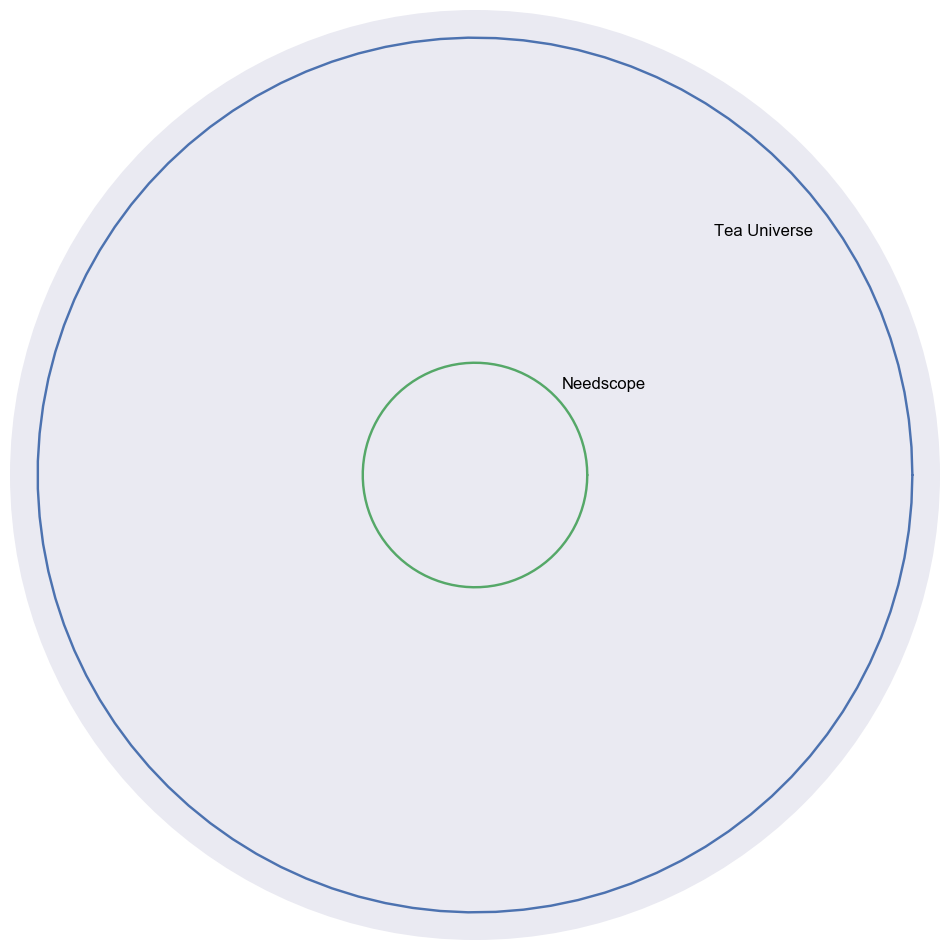

In [67]:
#Universe
fig1 = plt.figure(figsize=(12, 16), dpi=80, facecolor='w', edgecolor='k')
ax = fig1.add_subplot(1,1,1, polar=True)

ax.plot(np.linspace(0, 2*np.pi, 100), np.ones(100)*pow(universe_length/math.pi,.5))
ax.text(math.pi/4, pow(universe_length/math.pi,.5)-150, 'Tea Universe', size=12, color='k')
ax.plot(np.linspace(0, 2*np.pi, 100), np.ones(100)*pow(needscope_length/math.pi,.5))
ax.text(math.pi/4, pow(needscope_length/math.pi,.5)+15, 'Needscope', size=12, color='k')
ax.yaxis.set_ticklabels([])
ax.xaxis.set_ticklabels([])
ax.xaxis.grid(False)
ax.yaxis.grid(False)

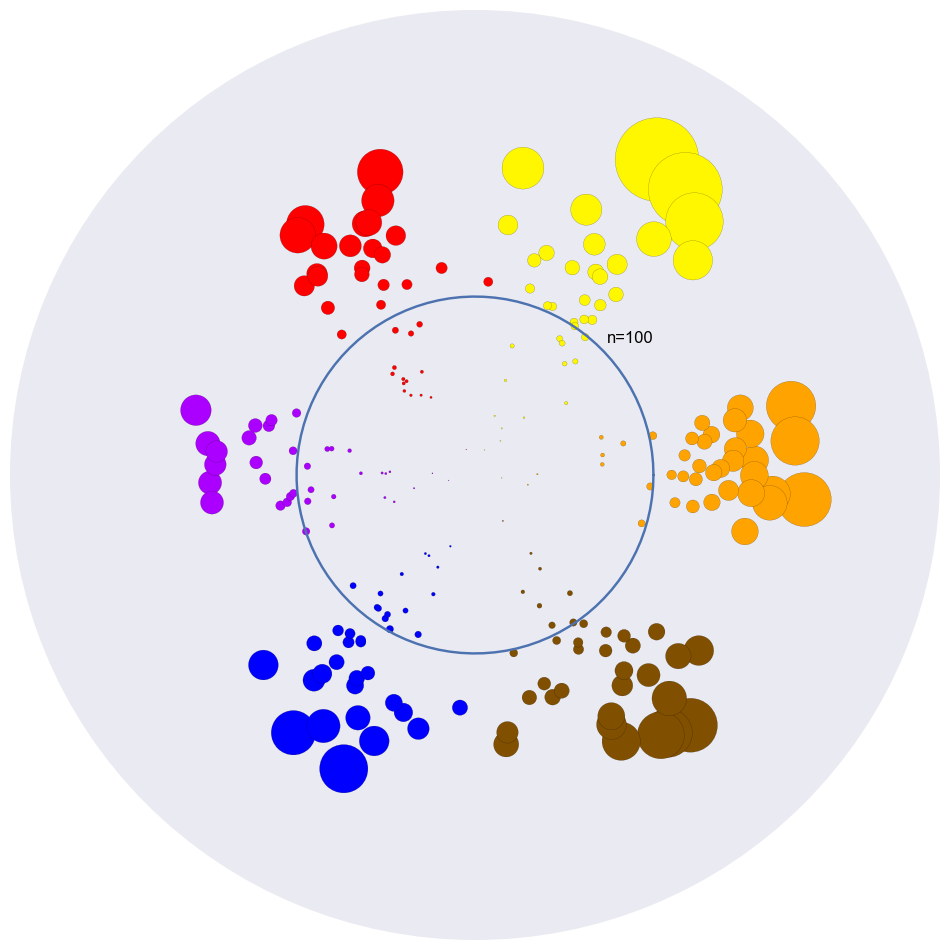

[16583 35522 27307 24381 17653  8553]
[ 0.12756252  0.27324826  0.21005546  0.1875476   0.13579335  0.06579281]


In [68]:
#View Needs
needscope['Log Counts'] = needscope['Counts'].apply(lambda e: math.log(e+1))
needscope.sort_values(by=['Counts'], inplace=True, ascending=False)

fig1 = plt.figure(figsize=(12, 16), dpi=80, facecolor='w', edgecolor='k')
ax = fig1.add_subplot(1,1,1, polar=True)

JITTER = math.pi/18
colour_coords = [2*math.pi/3,math.pi/3,0,5*math.pi/3,4*math.pi/3,math.pi]
colours = [[1,0,0],[1,.97,0],[1,.64,0],[.5,.31,0],[0,0,1],[.67,0,1]]

labels = []
labels_x = []
labels_y = []

LABEL_N = 3
BUBBLE_SCALE = .3

for i, colour in enumerate(needscope_colours):
    colour_df = needscope[needscope['Top Level'] == colour].drop_duplicates(subset=['Need'])
    length = len(colour_df)
    
    xs = [colour_coords[i]]*length+np.random.standard_normal(length)*JITTER
    ys = colour_df['Log Counts']
    
    colour_labels = colour_df.iloc[:LABEL_N].ix[:,'Need'].tolist()
    labels.append(colour_labels)
    labels_x.append(xs[:LABEL_N])
    labels_y.append(ys[:LABEL_N])

    ax.scatter(xs, ys,c=colours[i], s=colour_df['Counts']*BUBBLE_SCALE, lw=0.1)
    
ax.plot(np.linspace(0, 2*np.pi, 100), np.ones(100)*math.log(100))
ax.text(math.pi/4, math.log(100)+.2, 'n=100', size=12, color='k')

labels = [item for sublist in labels for item in sublist]
labels_x = [item for sublist in labels_x for item in sublist]
labels_y = [item for sublist in labels_y for item in sublist]
    
texts = []
#for x, y, s in zip(labels_x, labels_y, labels):
    #texts.append(ax.text(x, y, s, size=8, color='k'))
    #ax.text(x, y, s, size=8, color='k')


adjust_text(texts, size=5, arrowprops=dict(arrowstyle="-", color='r', lw=0.5))    
    
ax.xaxis.grid(False)
ax.yaxis.grid(False)
ax.set_xlim(0, 20)
ax.yaxis.set_ticklabels([])
ax.xaxis.set_ticklabels([])
plt.show()

print(full_sector_sizes)
print(np.array(full_sector_sizes)/sum(full_sector_sizes))

In [ ]:
main_data['Source'].value_counts()

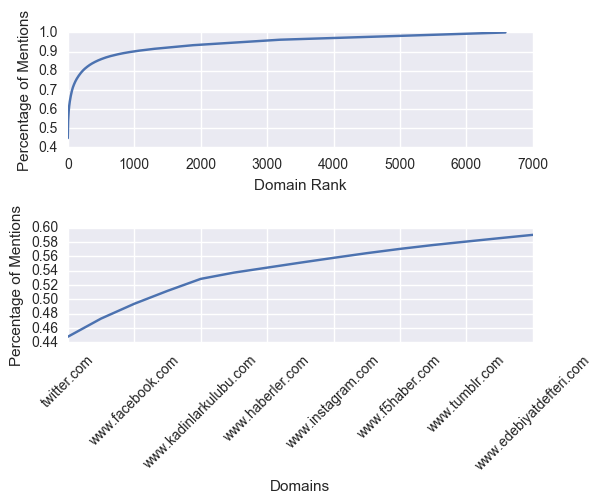

In [69]:
#Domains
fig1 = plt.figure()
ax1 = fig1.add_subplot(2,1,1)
ax2 = fig1.add_subplot(2,1,2)
fig1.subplots_adjust(hspace=.7)

sns.set_style("darkgrid")

perc = np.array(np.cumsum(main_data['Domain'].value_counts()))/len(main_data)
ax1.plot(perc)
ax1.set_xlabel('Domain Rank')
ax1.set_ylabel('Percentage of Mentions')

perc = np.array(np.cumsum(main_data['Domain'].value_counts()[:15]))/len(main_data)
ax2.plot(perc)
ax2.set_xlabel('Domains')
ax2.set_ylabel('Percentage of Mentions')
xticks = main_data['Domain'].value_counts()[:15].index
ax2.set_xticklabels(xticks, rotation=45)

plt.show()

In [ ]:
colour = needscope[needscope['Top Level'] == 'Yellow'].sort_values(by='Counts', ascending=False)
colour.iloc[:5].ix[:,['Need','Counts','Anja','Sentiment BW','Sentiment TNS']]

2193
310


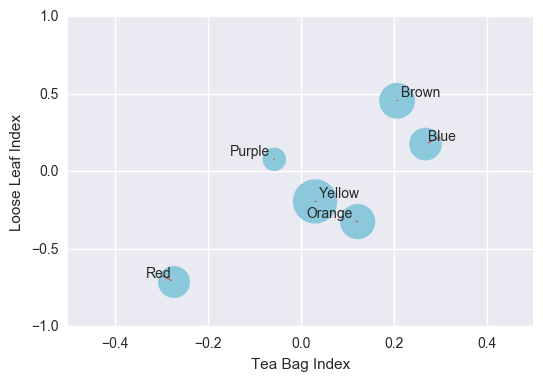

In [77]:
#Bag vs Loose
JOIN_BY = 'Top Level'
BUBBLE_SCALE = .6

print(len(main_data[main_data['Tea Type: Bag'] == 1]))
print(len(main_data[main_data['Tea Type: Loose Leaf'] == 1]))

bag = find_cat_need_overindex(main_data, 'Tea Type: Bag')
loose = find_cat_need_overindex(main_data, 'Tea Type: Loose Leaf')
bag.rename(columns={'Score': 'Bag Score', 'Dom Counts': 'Bag Dom Counts'}, inplace=True)
loose.rename(columns={'Score': 'Loose Score', 'Dom Counts': 'Loose Dom Counts'}, inplace=True)
#loose.drop(subset=['Need','Top Level','Counts'])
joint = pd.merge(bag, loose, on=['ID','Need','Top Level','Counts'])
joint['Weighted Bag Score'] = joint['Bag Score']*joint['Counts']
joint['Weighted Loose Score'] = joint['Loose Score']*joint['Counts']
#joint.to_csv('../Outputs/MajorThemes/BagVsLoose.csv', encoding='utf-8', quoting=csv.QUOTE_ALL, index=False)
d_group = joint.groupby([JOIN_BY]).mean()
d_group['Log(Bag Score)'] = (d_group['Weighted Bag Score']/d_group['Counts']).apply(lambda e: math.log(e))
d_group['Log(Loose Score)'] = (d_group['Weighted Loose Score']/d_group['Counts']).apply(lambda e: math.log(e))

xs = d_group['Log(Bag Score)']
ys = d_group['Log(Loose Score)']

fig = plt.figure()
sns.set_style("darkgrid")
ax = fig.add_subplot(1,1,1)
ax.scatter(xs,ys, s=d_group['Counts']*BUBBLE_SCALE, c=[140/255,200/255,219/255],
          lw = 0)
ax.set_xlabel('Tea Bag Index')
ax.set_ylabel('Loose Leaf Index')
ax.set_xlim([-.5,.5])
ax.set_ylim([-1,1])

#for i, txt in enumerate(anja_group.index):
    #ax.annotate(txt, (xs[i],ys[i]), size=8)

texts = []
for x, y, s in zip(xs, ys, d_group.index):
    texts.append(ax.text(x, y, s, size=10))
    
adjust_text(texts, size=5, arrowprops=dict(arrowstyle="-", color='r', lw=0.5))

plt.show()

In [93]:
#main_data[main_data['Tea Type: Bag'] == 1]['Snippet'].tolist()
main_data[main_data['Brand: Lipton'] == 1]['Sentiment'].mean()
#main_data[main_data['Brand: Caykur'] == 1]['Sentiment'].mean()
#main_data[main_data['Brand: Dogadan'] == 1]['Sentiment'].mean()

10.587363669759675

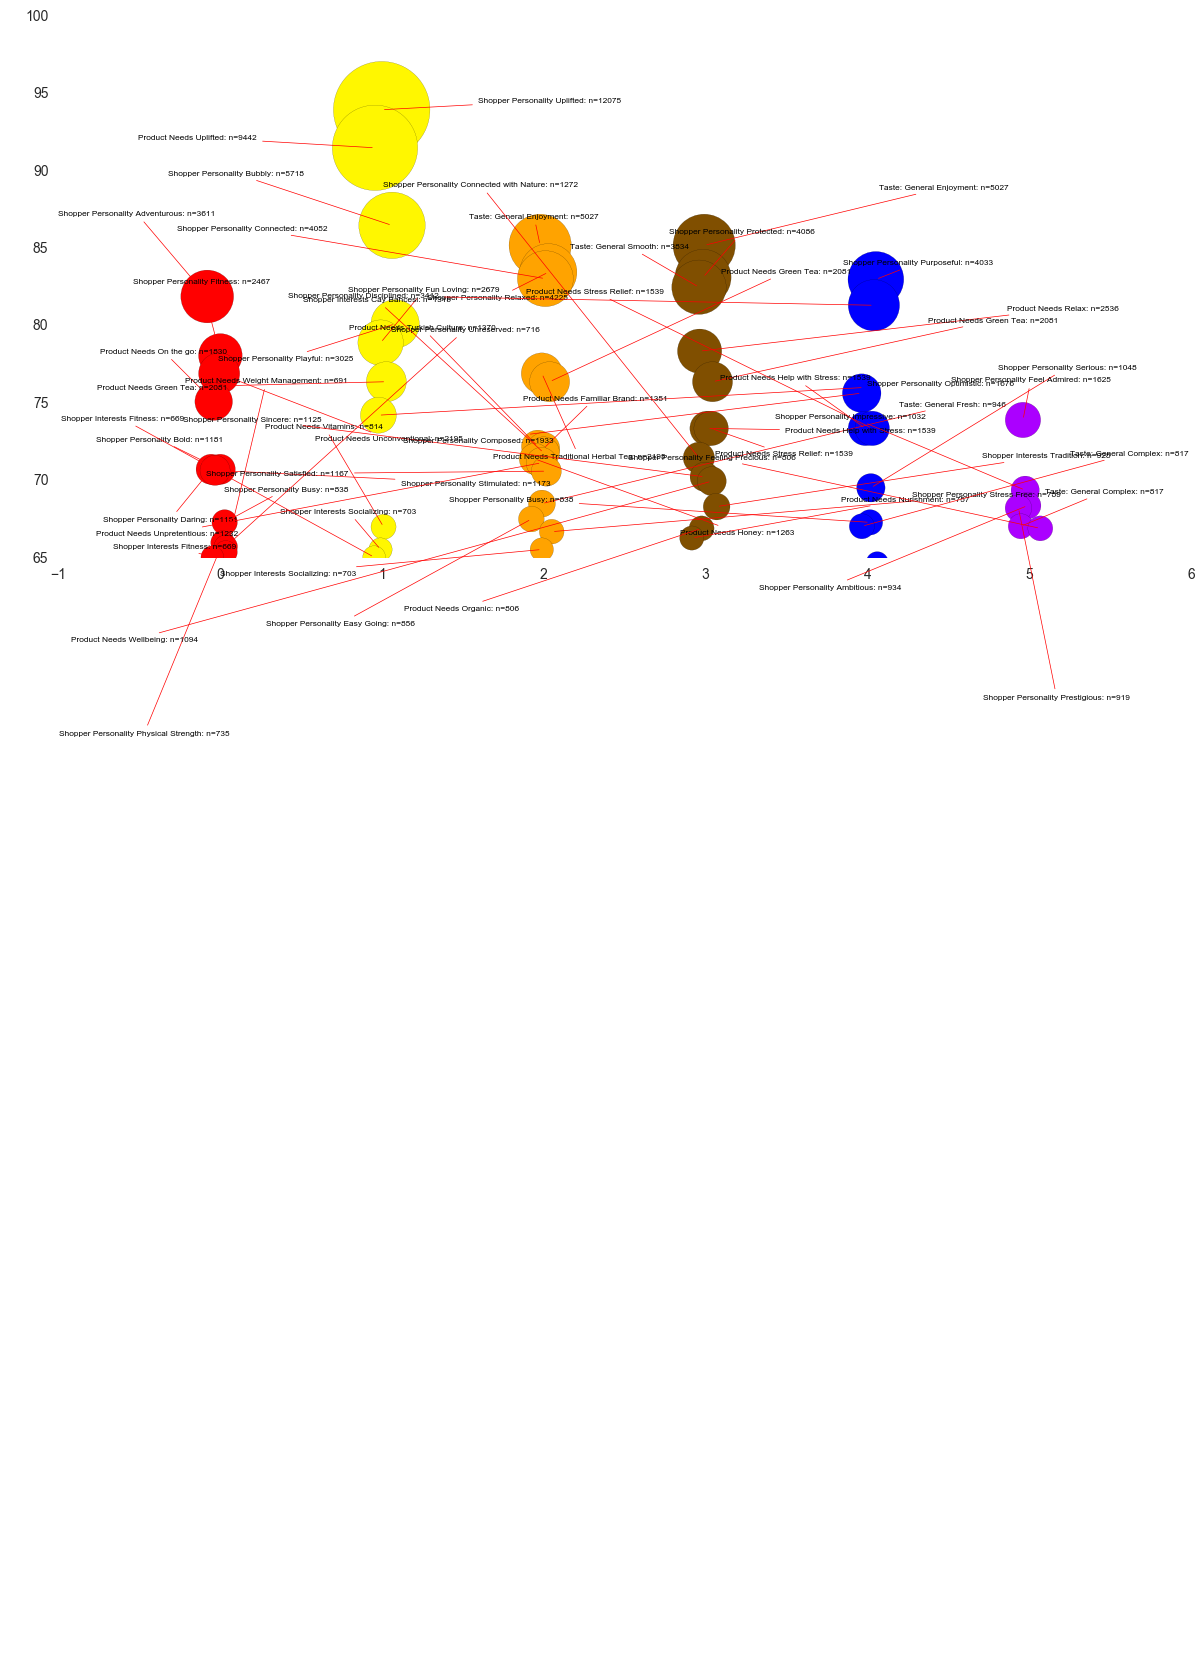

In [87]:
#Top needs per colour

fig = plt.figure(figsize=(12, 6), dpi=80)
sns.set_style("darkgrid")
ax = fig.add_subplot(1,1,1)

TOP_X = 5
needscope['Log Counts'] = needscope['Counts'].apply(lambda e: math.log(e+1))
needscope['Labels'] = needscope['Need'].astype(str) + ': n=' + needscope['Counts'].astype(str)
needscope.sort_values(by=['Counts'], inplace=True, ascending=False)
colours = [[1,0,0],[1,.97,0],[1,.64,0],[.5,.31,0],[0,0,1],[.67,0,1]]

labels = []
labels_x = []
labels_y = []

for ix, colour in enumerate(needscope_colours):
    colour_df = needscope[needscope['Top Level'] == colour].drop_duplicates(subset=['Need'])

    '''
    ys = colour_df.iloc[:TOP_X].ix[:,'Log Counts']*10
    xs = np.random.standard_normal(TOP_X)*.03 + ix
    sizes = colour_df.iloc[:TOP_X].ix[:,'Counts']*.4
    colour_labels = colour_df.iloc[:TOP_X].ix[:,'Labels']
    
    labels.append(colour_labels)
    labels_x.append(xs[:TOP_X])
    labels_y.append(ys[:TOP_X])
    '''
    ys = colour_df.ix[:,'Log Counts']*10
    xs = np.random.standard_normal(len(ys))*.05 + ix
    sizes = colour_df.ix[:,'Counts']*.4
    colour_labels = colour_df.ix[:,'Labels']
    
    labels.append(colour_labels)
    labels_x.append(xs)
    labels_y.append(ys)

    
    ax.scatter(xs, ys,c=colours[ix], s=sizes, lw=0.1)

labels = [item for sublist in labels for item in sublist]
labels_x = [item for sublist in labels_x for item in sublist]
labels_y = [item for sublist in labels_y for item in sublist]
    
texts = []
for x, y, s in zip(labels_x, labels_y, labels):
    pass
    texts.append(ax.text(x, y, s, size=6, color='k'))
    
adjust_text(texts, size=5, arrowprops=dict(arrowstyle="-", color='r', lw=0.5))
    
ax.patch.set_visible(False)
#ax.yaxis.set_ticklabels([])
#ax.xaxis.set_ticklabels([])
#ax.set_xlim([-1,3])
ax.set_ylim([65,100])
fig.tight_layout()
fig.savefig('../Outputs/Turkey/NeedsByColour.jpeg')
plt.show()

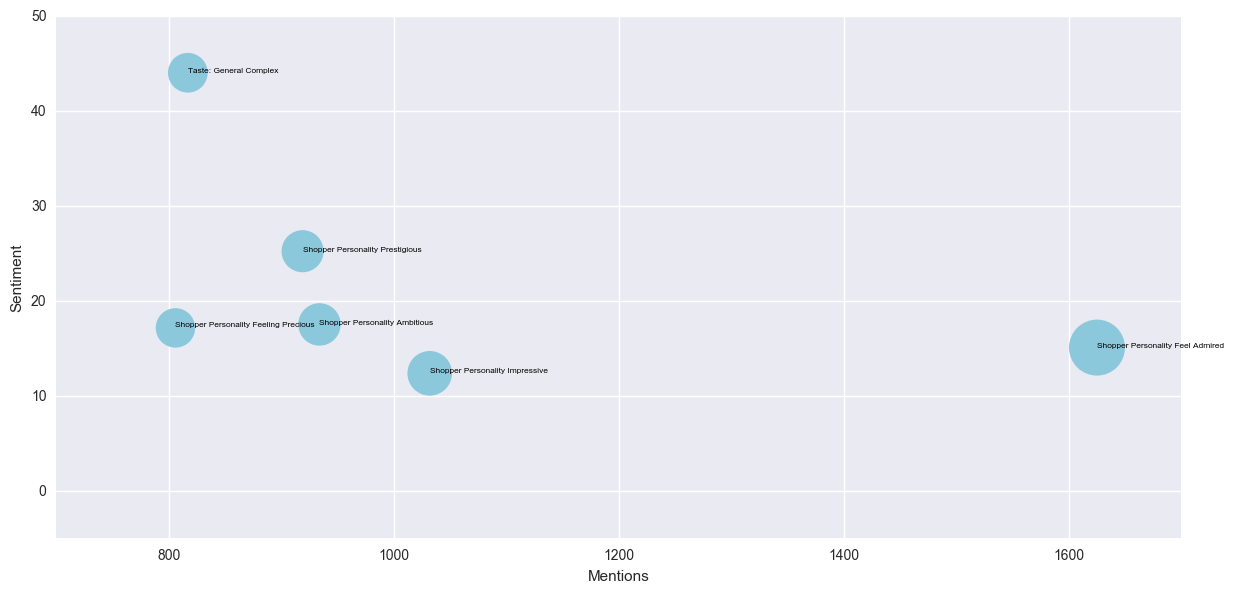

In [76]:
#Sentiment vs Mentions

fig1 = plt.figure(figsize=(12, 6), dpi=80)
ax1 = fig1.add_subplot(1,1,1)
fig1.subplots_adjust(hspace=.7)

sns.set_style("darkgrid")

needscope.sort_values(by=['Counts'], inplace=True, ascending=False)

COLOUR = 'Purple'
TOP_X = 15

colour_df = needscope[needscope['Top Level'] == COLOUR].drop_duplicates(subset=['Need'])
xs = colour_df.ix[:,'Counts']
ys = colour_df.ix[:,'Sentiment']
labels = colour_df.ix[:,'Need']


for x, y, s in zip(xs, ys, labels):
    if x < 500:
        pass
    else:
        #pass
        ax1.text(x, y+np.random.standard_normal(1)*.05, s, size=6, color='k')

ax1.scatter(xs,ys, s=xs, c=[140/255,200/255,219/255],
          lw = 0)
ax1.set_xlim([700,1700])
ax1.set_ylim([-5,50])

ax1.set_xlabel('Mentions')
ax1.set_ylabel('Sentiment')

fig1.tight_layout()
#fig1.savefig('../Outputs/Turkey/'+COLOUR+'.jpeg')

plt.show()

In [ ]:
sent_df = colour_df.ix[:,['Need','Counts']+emotion_list]
sent_df.ix[:,emotion_list] = sent_df.ix[:,emotion_list].div(sent_df['Counts'],axis=0)
#sent_df.iloc[:10].ix[:, emotion_list].plot.area(alpha=0.4)
sent_df.iloc[:10].ix[:, emotion_list+['Need']].set_index(drop=True, keys='Need').plot.area(alpha=0.4, rot=90)
plt.show()
sent_df.iloc[:10].ix[:, emotion_list+['Need']].set_index(drop=True, keys='Need')

In [ ]:
#Infusions
colours = [[1,0,0],[1,.97,0],[1,.64,0],[.5,.31,0],[0,0,1],[.67,0,1]]

infusion_matrix = []
infusion_names = []
for infusion in flavour_list:
    infusion_line = []
    infusion_names.append(infusion[13:])
    infusion_df = main_data[main_data[infusion] == 1]
    for colour in needscope_colours:
        infusion_line.append(len(infusion_df[infusion_df[colour] == 1]))

    infusion_matrix.append(infusion_line)
    
infusion_df = pd.DataFrame(np.array(infusion_matrix), columns=needscope_colours)
a = infusion_df.plot.bar(stacked=True,figsize=(12, 6), colors=colours)
a.xaxis.set_ticklabels(infusion_names)
fig = a.get_figure()
fig.tight_layout()
fig.savefig('../Outputs/Turkey/Infusions.jpeg')

In [ ]:
scales = full_sector_sizes/sum(full_sector_sizes)

In [ ]:
#Infusions
colours = [[1,0,0],[1,.97,0],[1,.64,0],[.5,.31,0],[0,0,1],[.67,0,1]]

infusion_matrix = []
infusion_names = []
for infusion in flavour_list:
    infusion_line = []
    infusion_names.append(infusion[13:])
    infusion_df = main_data[main_data[infusion] == 1]
    for colour in needscope_colours:
        infusion_line.append(len(infusion_df[infusion_df[colour] == 1]))
        
    infusion_line = np.array(infusion_line)/sum(infusion_line)
    infusion_line = infusion_line/scales
    infusion_matrix.append(infusion_line)
    
infusion_df = pd.DataFrame(np.array(infusion_matrix), columns=needscope_colours)
a = infusion_df.plot.bar(stacked=True,figsize=(12, 6), colors=colours, legend=False)
a.xaxis.set_ticklabels(infusion_names)
fig = a.get_figure()
fig.tight_layout()
fig.savefig('../Outputs/Turkey/InfusionsScaled.jpeg')

# Other

Other funcrtions

In [ ]:
from utils.analysis.top_features import top_mentioned_users, top_hashtags
from ast import literal_eval

top_authors_dfs = []
top_hashtags_dfs = []
main_data['Hashtags'] = main_data['Hashtags'].apply(lambda e: literal_eval(e))
main_data['Mentioned Users'] = main_data['Mentioned Users'].apply(lambda e: literal_eval(e))
for colour in needscope_colours:
    top_author = top_mentioned_users(main_data[main_data[colour] == 1]['Mentioned Users'])
    top_hashtag = top_hashtags(main_data[main_data[colour] == 1]['Hashtags'])
    top_authors_dfs.append(top_authors)
    top_hashtags_dfs.append(top_hashtags)
    top_author[:10].to_csv('../Outputs/Authors'+colour+'.csv', encoding='utf-8', quoting=csv.QUOTE_ALL, index=False)
    top_hashtag[:10].to_csv('../Outputs/Hashtag'+colour+'.csv', encoding='utf-8', quoting=csv.QUOTE_ALL, index=False)

In [ ]:
main_data['Sentiment'].value_counts()

In [ ]:
a = main_data['Sentiment']>0
b = main_data['MainSentiment']>0
main_data.groupby([a,b]).count() 

In [ ]:
main_data['Domain'].value_counts()

In [ ]:
len(main_data[main_data['e066'] == 1])

In [ ]:
main_data.columns.values.tolist()